# Bibliotecas

In [55]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.operators.crossover.pntx import TwoPointCrossover

# Dados

In [56]:
start_date = '2022-01-01'
end_date = '2022-12-31'
initial_value = 100000

adj_close_df = pd.read_csv('relatorios/preco-ativos.csv', index_col=0, parse_dates=True)
daily_return = np.log(adj_close_df / adj_close_df.shift(1)).dropna()

rebalance_dates = pd.DatetimeIndex(pd.read_csv('relatorios/datas-fim-de-mes.txt', header=None)[0])
rebalance_dates = rebalance_dates[(rebalance_dates>=start_date) & (rebalance_dates <= end_date)]

comeco = rebalance_dates[0]
df_rebalanco = daily_return.loc[:comeco]

In [ ]:
portfolio_value = initial_value
portfolio_values = []
dates = []
weights_history = []

# Modelo
class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, **kwargs):
        super().__init__(n_var=len(mu), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
    def _evaluate(self, x, out, *args, **kwargs):
        expected_return = self.mu.T @ x
        risk = x.T @ self.cov @ x
        out["F"] = [risk, -expected_return]

class SumToOneRepair(Repair):
    def _do(self, problem, X, **kwargs):
        return X / np.sum(X, axis=1, keepdims=True)

for i in range(len(rebalance_dates)-1):
    # Selecionar dados até o rebalanceamento atual
    period_start = rebalance_dates[i]
    period_end = rebalance_dates[i+1]
    period_prices = adj_close_df.loc[:period_start]
    log_returns = daily_return.loc[:period_start]
    if log_returns.empty:
        continue
    mu = log_returns.mean()
    cov = log_returns.cov()

    # Otimizar portfólio
    problem = PortfolioProblem(mu, cov)
    algorithm = NSGA2(pop_size=100,
                      crossover=TwoPointCrossover(),
                      repair=SumToOneRepair())
    termination = get_termination("n_gen", 500)
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   verbose=False)
    
    weights = res.X[np.argmax((res.F[:, 1]*-1 - 0.02)/res.F[:, 0])]

    weights_history.append(weights)
    dates.append(period_start)

    # Calcular retorno do portfólio no mês seguinte
    next_period_prices = adj_close_df.loc[period_start:period_end]
    next_log_returns = np.log(next_period_prices / next_period_prices.shift(1)).dropna()
    monthly_returns = next_log_returns @ weights
    portfolio_return = np.exp(monthly_returns.sum()) - 1
    portfolio_value *= (1 + portfolio_return)
    portfolio_values.append(portfolio_value)

# Calcular métricas finais
portfolio_values = np.array(portfolio_values)
total_return = portfolio_value / initial_value - 1
n_years = (rebalance_dates[-1] - rebalance_dates[0]).days / 365
annualized_return = (portfolio_value / initial_value) ** (1/n_years) - 1
log_portfolio_returns = np.log(portfolio_values[1:] / portfolio_values[:-1])
annualized_volatility = log_portfolio_returns.std() * np.sqrt(12)
sharpe_ratio = (annualized_return - 0.02) / annualized_volatility

# Maximum Drawdown
cum_values = pd.Series(portfolio_values, index=dates[:len(portfolio_values)])
peak = cum_values.cummax()
drawdown = (cum_values - peak) / peak
max_drawdown = drawdown.min()

print(f"Retorno anualizado: {annualized_return:.2%}")
print(f"Volatilidade anualizada: {annualized_volatility:.2%}")
print(f"Índice de Sharpe: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Valor final do portfólio: ${portfolio_value:.2f}")

Retorno anualizado: 62.03%
Volatilidade anualizada: 43.17%
Índice de Sharpe: 1.39
Maximum Drawdown: -21.45%
Valor final do portfólio: $155109.05


[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Valor ($)')

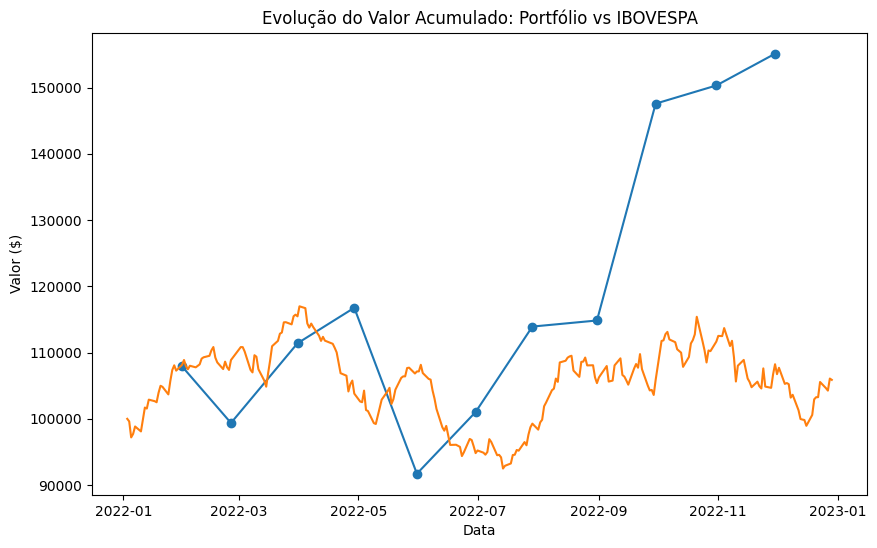

In [58]:
import matplotlib.pyplot as plt
# Baixar dados do IBOVESPA (índice B3)
ibov_data = yf.download('^BVSP', start=start_date, end=end_date, auto_adjust=False)
ibov_prices = ibov_data['Adj Close']

# Calcular evolução do valor investido no IBOVESPA (mesma lógica, inicial 10k)
ibov_values = [initial_value]
for i in range(1, len(ibov_prices)):
    ret = ibov_prices.iloc[i] / ibov_prices.iloc[i-1] - 1
    if isinstance(ret, pd.Series):
        ret = ret.values[0]
    ibov_values.append(ibov_values[-1] * (1 + float(ret)))
ibov_values = np.array(ibov_values)

# Ajustar datas para o mesmo eixo do portfólio
#ima_plot_dates = IMA.index
ibov_plot_dates = ibov_prices.index

plt.figure(figsize=(10, 6))
plt.plot(dates[:len(portfolio_values)], portfolio_values, marker='o', label='Portfólio NSGA-II')
plt.plot(ibov_plot_dates, ibov_values, label='IBOVESPA - $10k inicial')
#plt.plot(ima_plot_dates, ima_values)
plt.title('Evolução do Valor Acumulado: Portfólio vs IBOVESPA')
plt.xlabel('Data')
plt.ylabel('Valor ($)')

In [59]:

# Adicionar esta linha:
tickers = adj_close_df.columns.tolist()
# Print das ações presentes na carteira ao final (normalizado para porcentagem)
final_weights = weights_history[-1]
acoes_presentes = [ticker for ticker, peso in zip(tickers, final_weights) if peso > 0]
pesos_percentuais = [peso * 100 for peso in final_weights]

print("Ações presentes na carteira ao final:", acoes_presentes)
print("Pesos finais (%):", [f"{ticker}: {peso}%" for ticker, peso in zip(acoes_presentes, pesos_percentuais)])

print(f"Valor final do portfólio: ${portfolio_value:.2f}")

Ações presentes na carteira ao final: ['ABEV3', 'B3SA3', 'BBAS3', 'BBDC4', 'BBSE3', 'BPAC11', 'ELET3', 'EMBR3', 'ENEV3', 'EQTL3', 'GGBR4', 'ITSA4', 'ITUB4', 'JBSS3', 'PETR3', 'PETR4', 'PRIO3', 'RAIL3', 'RENT3', 'SUZB3', 'VALE3', 'BTC', 'ETH', 'IMA-B5', 'IMA-B5MAIS', 'IMA-S', 'IRFM-1', 'IRFM-1MAIS']
Pesos finais (%): ['ABEV3: 0.0008283193891812888%', 'B3SA3: 0.0076967507708373415%', 'BBAS3: 0.004537784499594523%', 'BBDC4: 0.0006414672225300883%', 'BBSE3: 0.003916936493752346%', 'BPAC11: 0.23739112504137372%', 'ELET3: 3.953445828135364e-05%', 'EMBR3: 4.9064161333334546e-05%', 'ENEV3: 0.13512104470438416%', 'EQTL3: 0.0021422231969145515%', 'GGBR4: 0.000585547073394275%', 'ITSA4: 0.00046239254178742753%', 'ITUB4: 0.0011770115733419418%', 'JBSS3: 0.004130362507771448%', 'PETR3: 0.0003891731422437391%', 'PETR4: 0.0024917655783634296%', 'PRIO3: 99.54646910024827%', 'RAIL3: 0.0035725233078099166%', 'RENT3: 0.024211064074478487%', 'SUZB3: 0.0007173483444019951%', 'VALE3: 0.0003381783909819775%'